In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.0 MB/s eta 0:00:00
Using device: cuda


In [2]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


In [3]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [4]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [5]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [6]:
model = timm.create_model(
    "inception_v3",
    pretrained=True,
    num_classes=num_classes,
    aux_logits=True
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)


In [8]:
def forward_pass(model, x):
    outputs = model(x)

    if isinstance(outputs, tuple):
        main_out = outputs[0]
        aux_out = outputs[1]
        return main_out, aux_out
    else:
        return outputs, None


In [9]:
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)


In [10]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [11]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader,
                desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x,y in pbar:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)

        # Handle tuple (Inception safety)
        if isinstance(outputs, tuple):
            main_out, aux_out = outputs
            loss = criterion(main_out, y) + 0.4 * criterion(aux_out, y)
            out = main_out
        else:
            loss = criterion(outputs, y)
            out = outputs

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = out.argmax(1)
        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(
        train_targets, train_preds
    )

    train_out = {k:v.compute().item() for k,v in train_metrics.items()}

    print(f"\n[TRAIN] loss: {train_loss:.4f}, "
          f"accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, "
          f"recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, "
          f"specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, "
          f"mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # ===== STORE TRAIN HISTORY =====
    history["loss"].append(train_loss)
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)
    history["mcc"].append(train_out["mcc"])
    history["auc"].append(train_out["auc"])

    for m in train_metrics.values():
        m.reset()

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    pbar = tqdm(val_loader, desc="Validating Model")

    with torch.no_grad():
        for x,y in pbar:
            x,y = x.to(device), y.to(device)

            outputs = model(x)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, y)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(outputs, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(
        val_targets, val_preds
    )

    val_out = {k:v.compute().item() for k,v in val_metrics.items()}

    print(f"[VAL]   loss: {val_loss:.4f}, "
          f"accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, "
          f"recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, "
          f"specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, "
          f"mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    # ===== STORE VAL HISTORY =====
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)
    history["val_mcc"].append(val_out["mcc"])
    history["val_auc"].append(val_out["auc"])

    scheduler.step()

    for m in val_metrics.values():
        m.reset()

    # ===== EARLY STOPPING =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [01:00<00:00,  4.07it/s]



[TRAIN] loss: 0.8208, accuracy: 0.7739, precision: 0.7719, recall: 0.7739, f1_score: 0.7728, specificity: 0.8935, sensitivity: 0.7739, mcc: 0.6743, auc: 0.9095


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.57it/s]


[VAL]   loss: 0.2974, accuracy: 0.8166, precision: 0.8663, recall: 0.8166, f1_score: 0.8248, specificity: 0.9213, sensitivity: 0.8166, mcc: 0.7860, auc: 0.9776
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [01:01<00:00,  3.96it/s]



[TRAIN] loss: 0.4270, accuracy: 0.8814, precision: 0.8729, recall: 0.8814, f1_score: 0.8768, specificity: 0.9433, sensitivity: 0.8814, mcc: 0.8240, auc: 0.9686


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.61it/s]


[VAL]   loss: 0.3244, accuracy: 0.8885, precision: 0.8729, recall: 0.8885, f1_score: 0.8793, specificity: 0.9437, sensitivity: 0.8885, mcc: 0.8249, auc: 0.9686
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [01:01<00:00,  4.02it/s]



[TRAIN] loss: 0.3308, accuracy: 0.9036, precision: 0.8962, recall: 0.9036, f1_score: 0.8996, specificity: 0.9533, sensitivity: 0.9036, mcc: 0.8555, auc: 0.9813


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.56it/s]


[VAL]   loss: 0.2345, accuracy: 0.8927, precision: 0.8897, recall: 0.8927, f1_score: 0.8900, specificity: 0.9524, sensitivity: 0.8927, mcc: 0.8514, auc: 0.9832
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [01:00<00:00,  4.03it/s]



[TRAIN] loss: 0.2995, accuracy: 0.9061, precision: 0.9016, recall: 0.9061, f1_score: 0.9037, specificity: 0.9567, sensitivity: 0.9061, mcc: 0.8646, auc: 0.9842


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.63it/s]


[VAL]   loss: 0.4576, accuracy: 0.8007, precision: 0.8153, recall: 0.8007, f1_score: 0.7959, specificity: 0.9137, sensitivity: 0.8007, mcc: 0.7357, auc: 0.9651
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [01:00<00:00,  4.04it/s]



[TRAIN] loss: 0.2560, accuracy: 0.9253, precision: 0.9210, recall: 0.9253, f1_score: 0.9231, specificity: 0.9649, sensitivity: 0.9253, mcc: 0.8909, auc: 0.9884


Validating Model: 100%|██████████| 62/62 [00:08<00:00,  7.15it/s]


[VAL]   loss: 0.2683, accuracy: 0.8972, precision: 0.8840, recall: 0.8972, f1_score: 0.8894, specificity: 0.9520, sensitivity: 0.8972, mcc: 0.8465, auc: 0.9800
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [01:00<00:00,  4.03it/s]



[TRAIN] loss: 0.1923, accuracy: 0.9506, precision: 0.9513, recall: 0.9506, f1_score: 0.9510, specificity: 0.9772, sensitivity: 0.9506, mcc: 0.9304, auc: 0.9934


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.76it/s]


[VAL]   loss: 0.3427, accuracy: 0.8527, precision: 0.8519, recall: 0.8527, f1_score: 0.8518, specificity: 0.9301, sensitivity: 0.8527, mcc: 0.7867, auc: 0.9669
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [01:01<00:00,  4.01it/s]



[TRAIN] loss: 0.1741, accuracy: 0.9564, precision: 0.9540, recall: 0.9564, f1_score: 0.9552, specificity: 0.9785, sensitivity: 0.9564, mcc: 0.9345, auc: 0.9946


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.59it/s]


[VAL]   loss: 0.2888, accuracy: 0.9022, precision: 0.9039, recall: 0.9022, f1_score: 0.9016, specificity: 0.9571, sensitivity: 0.9022, mcc: 0.8670, auc: 0.9818
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [01:01<00:00,  4.01it/s]



[TRAIN] loss: 0.0992, accuracy: 0.9761, precision: 0.9761, recall: 0.9761, f1_score: 0.9761, specificity: 0.9887, sensitivity: 0.9761, mcc: 0.9656, auc: 0.9982


Validating Model: 100%|██████████| 62/62 [00:09<00:00,  6.51it/s]

[VAL]   loss: 0.2959, accuracy: 0.8702, precision: 0.9013, recall: 0.8702, f1_score: 0.8819, specificity: 0.9412, sensitivity: 0.8702, mcc: 0.8373, auc: 0.9859
Current LR: 4.357862e-04

Early stopping triggered.


In [12]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


InceptionV3(
  (Conv2d_1a_3x3): ConvNormAct(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2a_3x3): ConvNormAct(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Conv2d_2b_3x3): ConvNormAct(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU(inplace=True)
    )
  )
  (Pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): ConvNormAct(
    (conv): Conv2d(64, 80, kernel_size

In [13]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_targets = [], []
test_loss = 0

with torch.no_grad():
    for x,y in tqdm(test_loader, desc="Testing"):
        x,y = x.to(device), y.to(device)

        outputs = model(x)

        if isinstance(outputs, tuple):
            outputs = outputs[0]

        loss = criterion(outputs, y)
        test_loss += loss.item()

        preds = outputs.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

test_loss /= len(test_loader)

print("\nTest Loss:", test_loss)


Testing: 100%|██████████| 77/77 [00:11<00:00,  6.53it/s]


Test Loss: 0.30042390568732197


In [14]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print(classification_report(all_targets, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.7687    0.7958    0.7820       142
           1     0.9540    0.8737    0.9121       285
           2     0.9024    0.9946    0.9463       186

    accuracy                         0.8923       613
   macro avg     0.8751    0.8880    0.8801       613
weighted avg     0.8954    0.8923    0.8923       613



In [18]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


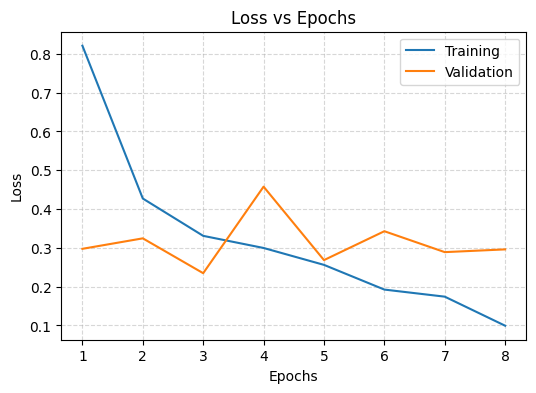

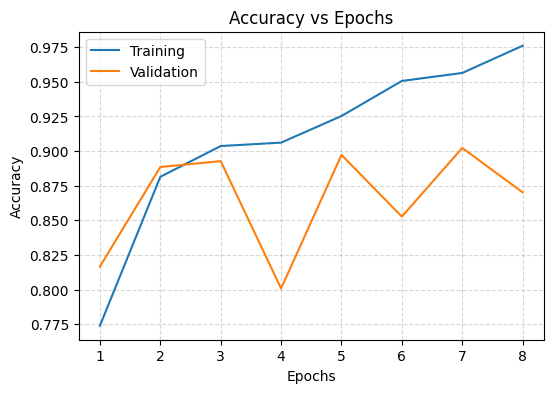

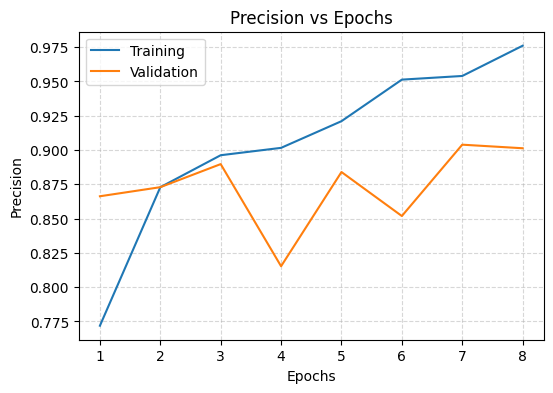

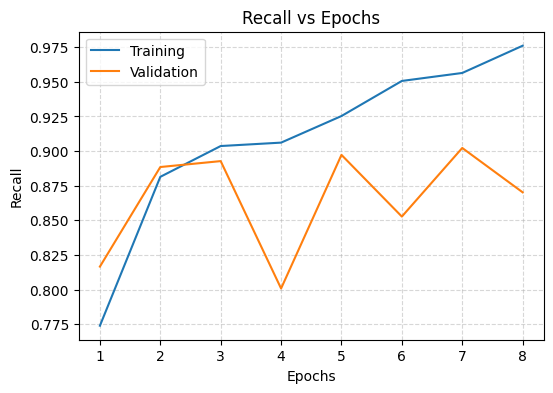

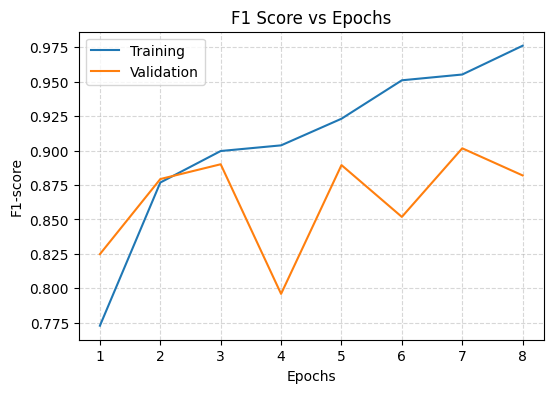

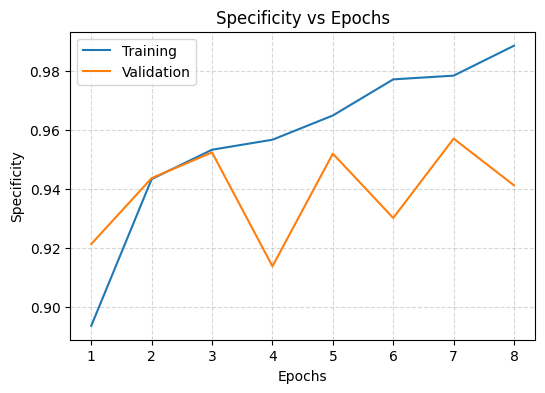

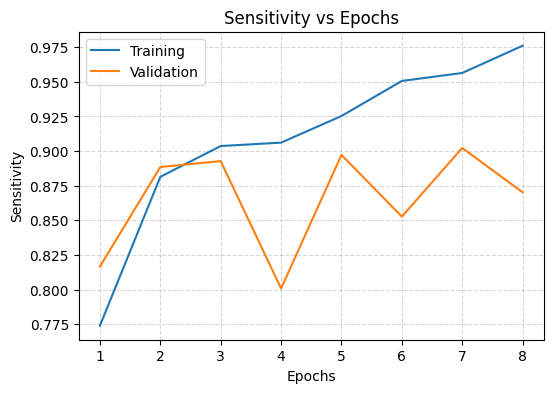

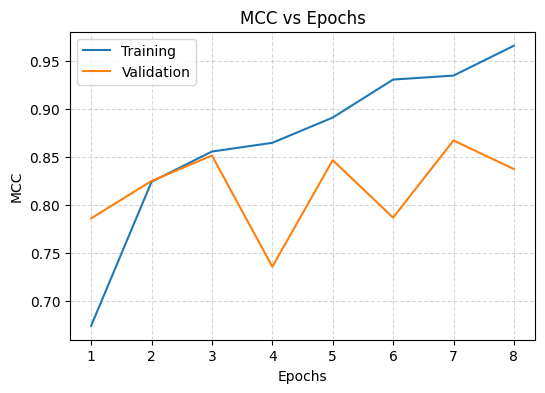

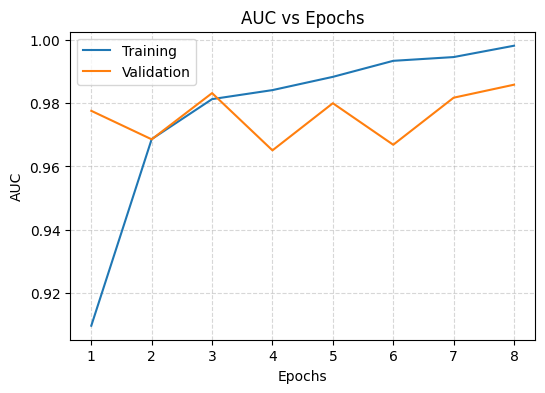

In [19]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
